# Veesion Data Science Challenge
Nelson Fernandez 

### Context
Veesion delivers a full AI video analytics solution for detecting shoplifting, serving clients in over 40 countries. What makes Veesion different to other companies is that their AI model plugs into the existing DRVs and IP cameras of the clients reducing the set up costs. As a consequence, Veesion's AI action recognition model must robustly handle videos of different qualities, across a wide range of environments, traffic levels, and event types.

### Goal
To provide an excellent quality of service, the Veesion AI team aims to minimize the number of false alerts while missing as few theft events as possible. Achieving this balance is essential for delivering strong ROI to clients and maintaining operator trust in the system.

### Scope
* As this is a 3h excercise, I'll code the most essential parts of the system, and provide recommendations for a follow up.
* I'll keep my code as suitable as possible for deployment: Modular and maintainable with classes & base models, stateles (ideal for interacting with different data inputs) and an easy CLI calling with basic loggin.
* I'll assume that all thefts were detected and are available in the provided event .CSV.
* I'll treat the clearly multi-class classification model as binary, eventhough this would **skyrocket the number of #FP** in a production environment.


#### Question 1: Plot the #FP = f(Recall) curve for each camera for which we have alerts in this CSV.


In [17]:
import os

from optimizer.io_utils import DataLoader
from optimizer.viz_utils import save_fp_recall_plots

data_path = os.path.join('data', 
                         'production_alerts_meta_data.csv'
            )

# Let's open the original dataframe.
# This function extracts the camera_id's and maps the theft labels as theft and generates a binary 'is_theft' collumn.
df = DataLoader(data_path, source_type="csv").load()

num_stores = df['store'].nunique()
num_cameras = df.groupby(['store', 'camera_id']).ngroups
num_theft_events = df['is_theft'].sum()
num_non_theft_events = (df['is_theft'] == 0).sum()

print(
    f"Summary: "
    f"Number of unique videos: {num_stores}, "
    f"Number of unique cameras: {num_cameras}, "
    f"Theft events: {num_theft_events}, "
    f"Non-theft events: {num_non_theft_events}"
)

# Now let's export the FP = f(recall) plots for each pair store, camera.
# For writting this function I've used sklearn's precision_recall_curve and tracked #FP
# using (probability >= th).astype(int) and comparing to the 'true' value  'is_theft'.
# The results are stored in 'plots/store_camera_id.png'
save_fp_recall_plots(df, output_dir="plots/")

Summary: Number of unique videos: 45, Number of unique cameras: 45, Theft events: 1601, Non-theft events: 154336


100%|██████████| 45/45 [00:01<00:00, 22.60it/s]


#### Question 2 : What can you deduce about the model's uniformness across these cameras?

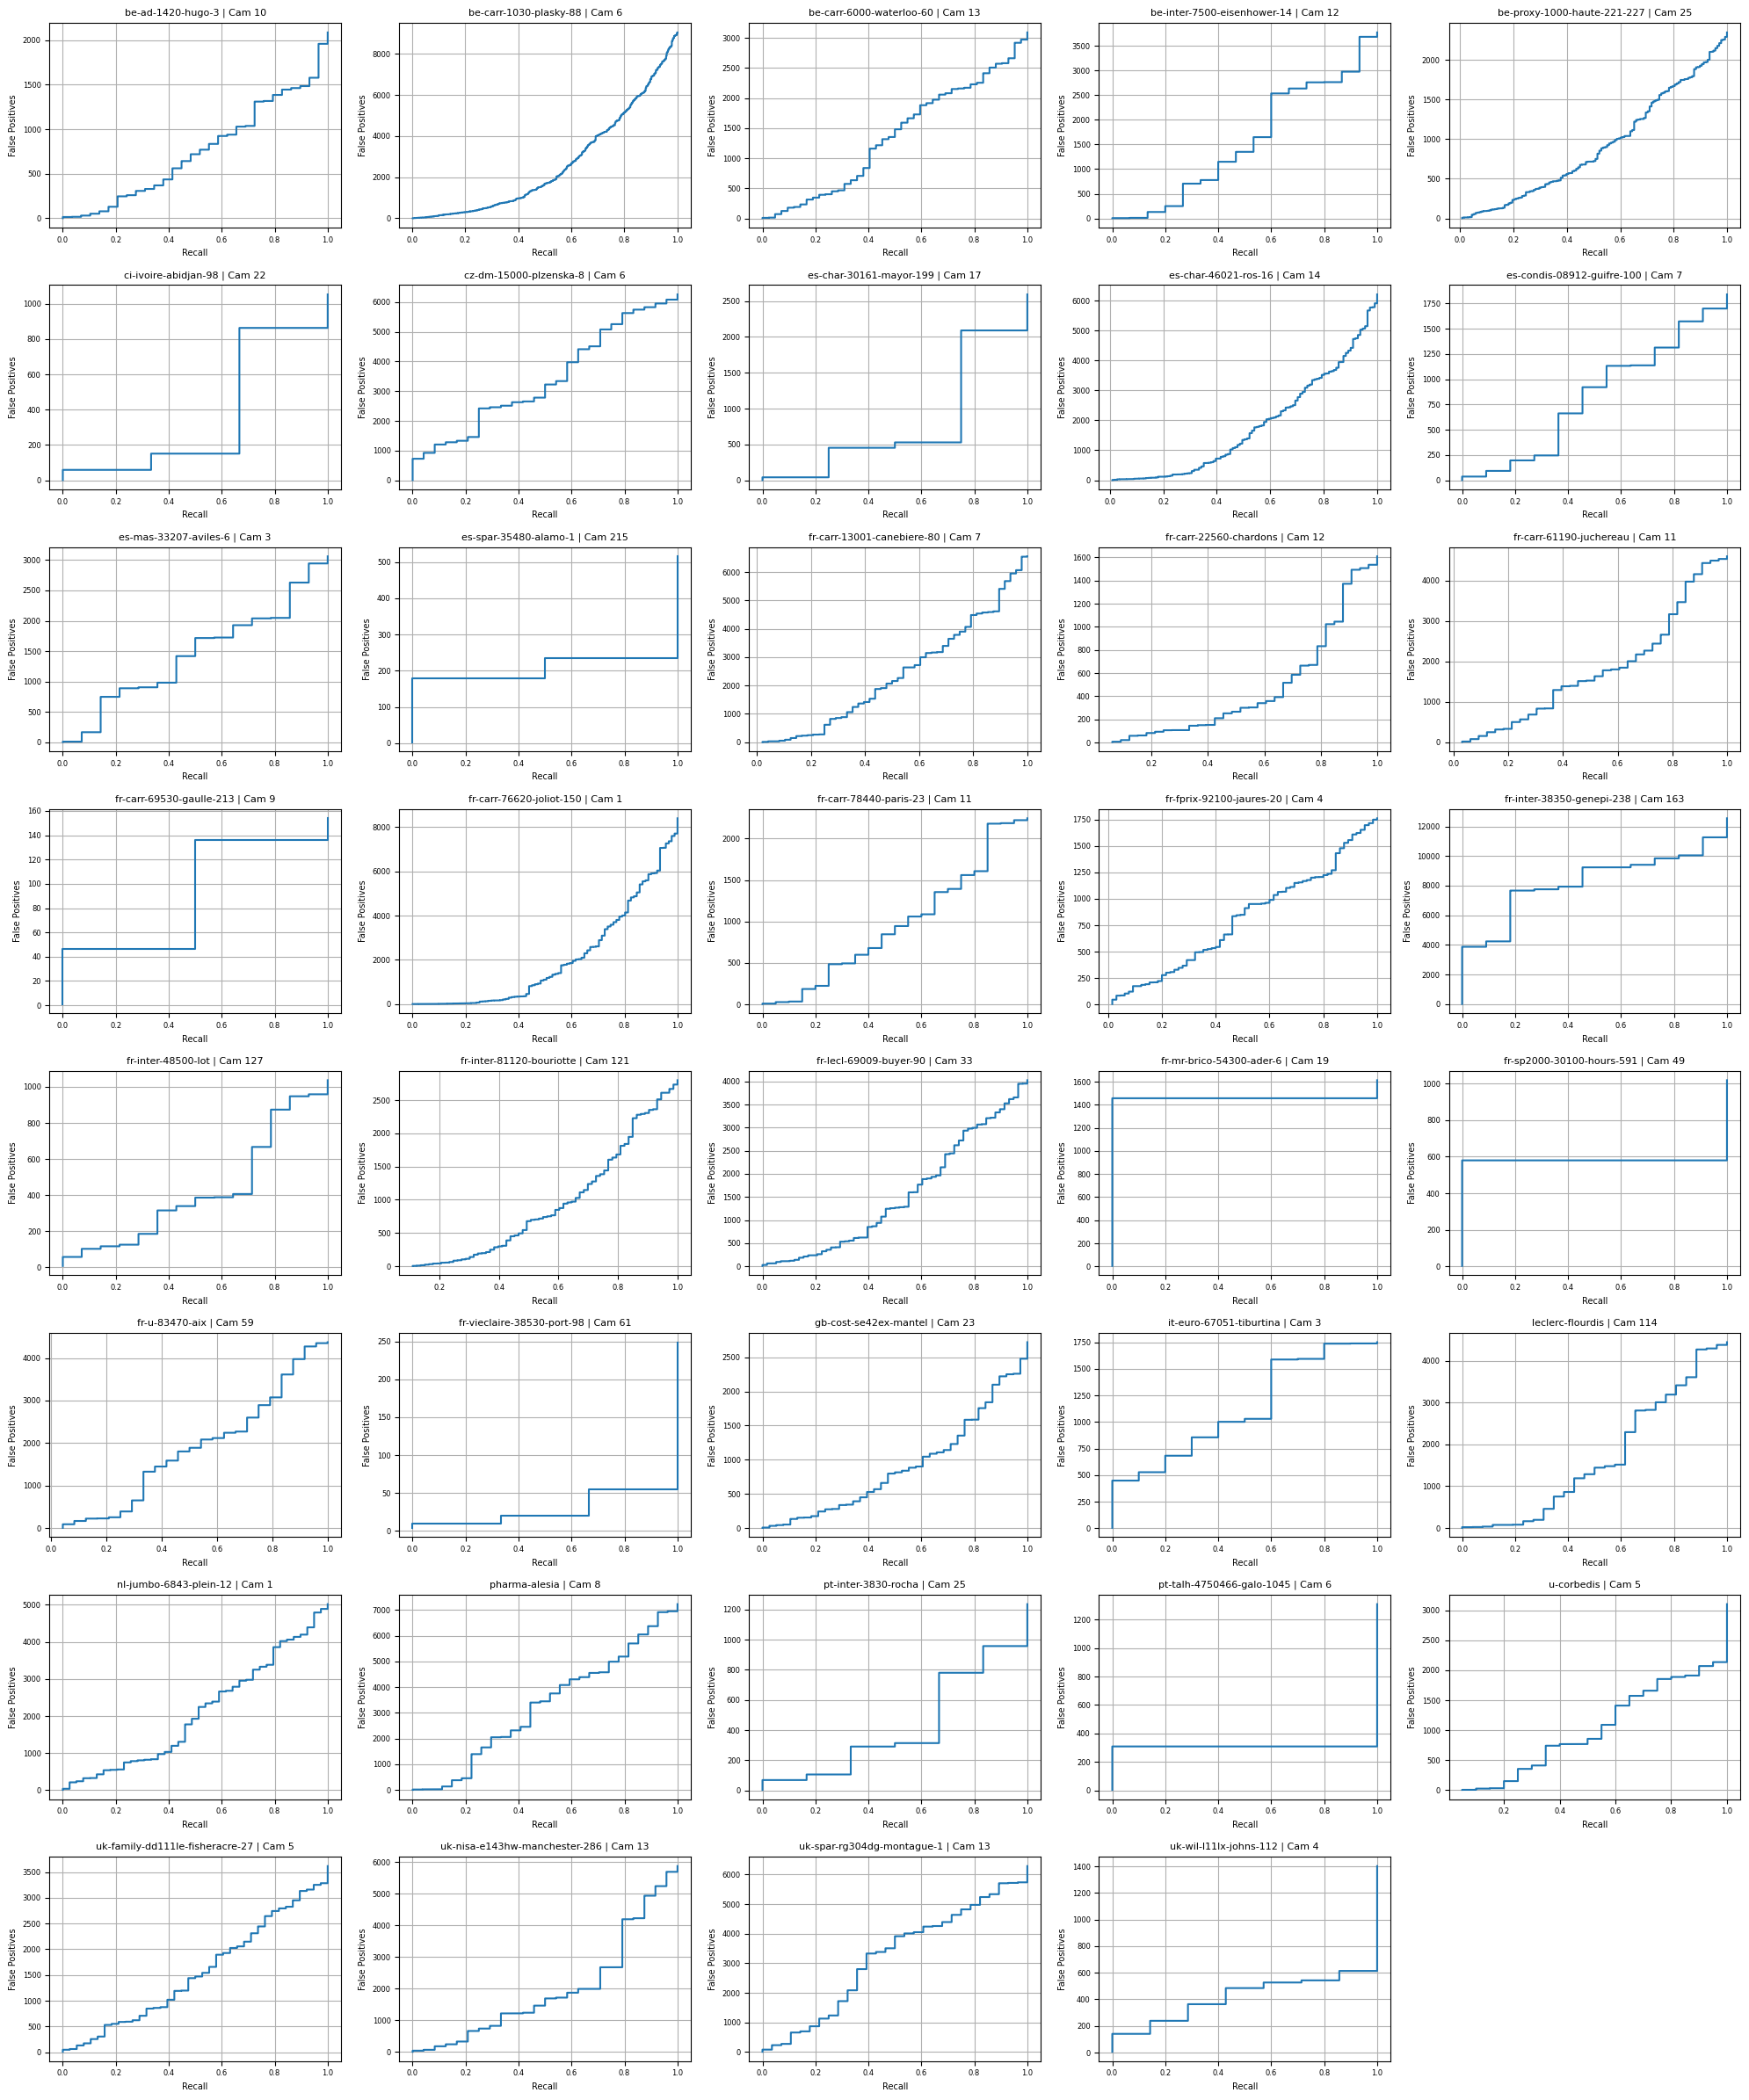

In [12]:
from optimizer.viz_utils import display_fp_vs_recall_grid

# Let's display the FP = f(recall) plots inline to discuss on them.
display_fp_vs_recall_grid(df, max_cols=5)


#### Global considerations:
1) Ideally we want the recall to be the highest possible as we do not want to miss any theft (x-axis). Nevertheless, high recall is paid expensively with #FPs that can go up to 10K for the most active cameras (y-axis)!

2) As consequence of the point (1) the overal model quality for that camera is related to the AUC, so flatter-curves are better. A good example is the bottom right curve (right uk-wil-l11lk-jhons-112) which has a flat slope most of the plot.

3) Some camerals produce a lot of #FP! (see top left second position be-carr-1030-plasky-88) we could benefit of these cases when doing global optimization.

4) Some curves are step-like, this is due to a relativelly small amount of theft events. More the number of events, the more smooth the curves are.

5) Of course, not all cameras produce the same amount of events, so we could benefit of normalization. Nevertheless, I'll keep it as it is, to focus at the client level.


#### Conclusion: 
   The model performance varies a lot depending on the camera, in some it is very good (uk-wil-l11lk-jhons-112) in others very bad (be-carr-1030-plasky-88). Also the number of theft events and #FP varies a lot. This means that we need for **camera level threshold management** to ensure quality of service. In other words, one threshold does not fit for all cameras.

### Question 3: Optimization

Let's agree that, without a particular choice of threshold, the default threshold is 0. Choosing a threshold higher than 0 for a camera thus has the effect of lowering its #FP and #TP. Let's call the total #FP the sum of the #FP for each camera in the data, and the total #TP the sum of the #TP for each camera. Find a combination of thresholds for all the cameras that, given a target reduction of total #FP, minimizes the reduction of total #TP.